In [117]:
import pandas as pd
import numpy as np
import intake

In [118]:
cat = intake.open_catalog('../catalogs/catalog.yml')
measures = cat.measures.read().set_index('cdtfa_id')
measures['pct_transit_unspecified'] = abs(measures['total_pct_transit'].fillna(0) -
                                       measures['pct_transit_capital'].fillna(0) -
                                      measures['pct_transit_ops'].fillna(0)).round(0)

In [119]:
measures[measures['county_name'] == 'Contra Costa']

,ballot_designation,county_fips,county_name,county_and_measure,lost_rate,total_pct_transit,pct_transit_ops,pct_transit_capital,pct_local_return,pct_hwy,pct_streets,pct_discretionary,pct_sum,year,amendable,change_feq,two_thirds_req,pct_transit_unspecified
cdtfa_id,,,,,,,,,,,,,,,,,,
24,Measure J,6013,Contra Costa,Contra Costa Measure J,0.005,0.327,0.188,0.139,NaN,0.255,0.264,0.13,0.976,2004,True,NaN,True,0.0


In [120]:
def county_lost_narrative(measures_df, county_name):
    measure_info = ''
    county_df = measures_df[measures_df['county_name'] == county_name]
    for _ix, row in county_df.iterrows():
        measure_info += f'* {row.ballot_designation}, enacted {int(row.year)}, {row.lost_rate * 100} percent sales tax\n'
    return measure_info

In [121]:
from scipy import stats
def county_lost_info(measures_df, county_name):
    
    measures_grouped = measures.groupby('county_name')
    lost_sums = measures_grouped.sum()
    num_losts = measures_grouped.size()
    county_total_rate = lost_sums.loc[county_name, 'lost_rate'] * 100
    if county_total_rate % 1 == 0:
        county_total_rate = int(county_total_rate)
    rate_percentile = int(stats.percentileofscore(lost_sums['lost_rate'] * 100, county_total_rate))
    transit_percentile = int(stats.percentileofscore(lost_sums['total_pct_transit']/num_losts,
                            lost_sums.loc[county_name,'total_pct_transit'] / num_losts[county_name]))
    
    measure_info = f'''\
The total sales tax rate of all LOSTs in {county_name} County is {county_total_rate} percent. \
This is higher than the total rate in {rate_percentile} percent of California counties with active LOSTs. \
LOSTs in {county_name} County dedicate about {int(lost_sums.loc[county_name,'total_pct_transit'] / num_losts[county_name]*100)} \
percent of their revenue to public transit, a larger proportion than {transit_percentile} percent of counties.\
    '''
    return measure_info

In [122]:
print(county_lost_info(measures, 'Contra Costa'))

The total sales tax rate of all LOSTs in Contra Costa County is 0.5 percent. This is higher than the total rate in 46 percent of California counties with active LOSTs. LOSTs in Contra Costa County dedicate about 32 percent of their revenue to public transit, a larger proportion than 74 percent of counties.    


## Los Angeles County

### LOST Measures
* Prop A (year/rate/etc for each)
* Prop C
* Measure R
* Measure M

In [47]:
print(county_lost_narrative(measures, 'Los Angeles'))

* Proposition A, enacted 1980, 0.5 percent sales tax
* Proposition C, enacted 1990, 0.5 percent sales tax
* Measure R, enacted 2008, 0.5 percent sales tax
* Measure M, enacted 2016, 0.5 percent sales tax



In [48]:
print(county_lost_narrative(measures, 'Santa Clara'))

* Measure A, enacted 2000, 0.5 percent sales tax
* Measure B, enacted 2016, 12.5 percent sales tax
* Measure B, enacted 2016, 0.5 percent sales tax



In [12]:
measures['county_name'].unique()

array(['Alameda', 'Contra Costa', 'Fresno', 'Imperial', 'Los Angeles',
       'Madera', 'Marin', 'Merced', 'Monterey',
       'Monterey-Salinas Transit District', 'Napa', 'Orange', 'Riverside',
       'Sacramento', 'San Benito', 'San Bernardino', 'San Diego',
       'San Francisco', 'San Joaquin', 'San Mateo', 'Santa Barbara',
       'Santa Clara', 'Santa Cruz', 'Sonoma', 'Sonoma/Marin',
       'Stanislaus', 'Tulare'], dtype=object)

_chart of funding split across all measures_

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ucla')

In [36]:
def county_lost_chart(measures_df, county_name):
    
    plot_columns = ['pct_transit_ops', 'pct_transit_capital', 'pct_transit_unspecified', 'pct_hwy',
               'pct_local_return', 'pct_streets', 'pct_discretionary']
    display_columns = ['Transit Operations', 'Transit Capital', 'Transit Unspecified',
                  'Highway', 'Local Return', 'Streets', 'Discretionary']
    
    county_measures = measures_df[measures_df['county_name'] == county_name]
    
    county_measures = county_measures.rename(columns=dict(zip(plot_columns, display_columns)))
#     display(county_measures)
    to_plot = county_measures[display_columns].multiply(county_measures['lost_rate'], axis='index').sum()
    to_plot = to_plot.rename('total_rate')
    to_plot = pd.DataFrame(to_plot)
    to_plot['Percentage'] = (100 * to_plot['total_rate'] / to_plot['total_rate'].sum()).round(0).astype(int)
    to_plot.index = to_plot.index + ', ' + to_plot['Percentage'].astype(str) + '%'
    to_plot.rename(columns={'Percentage':''}, inplace=True) #remove 'Percentage' label from chart
    
    fig, ax = plt.subplots(figsize=(200,200))
#     display(to_plot[''])
    ax = to_plot[''].plot.pie(y=0, figsize=(5,5), legend=False)
#     ax.set_title(f'Approximate Funding Distribution (All LOSTs) \n {county_name}')
    ax.set_title('')
    plt.savefig(f'../reports/figures/{county_name}_lost.png', bbox_inches = "tight", facecolor='white')
    return

In [37]:
def all_county_charts():
    for county_name in measures['county_name'].unique():
        try:
#             print(county_name)
            county_lost_chart(measures, county_name)
        except:
            print(f'Chart failed for {county_name}')
    return

In [38]:
# all_county_charts()

In [17]:
sco_url = 'https://bythenumbers.sco.ca.gov/download/6dj3-r4jw/application%2Fvnd.openxmlformats-officedocument.spreadsheetml.sheet'

In [18]:
sco_entities = pd.read_excel(sco_url, sheet_name='ENTITIES')

In [19]:
sco_rev_exp = pd.read_excel(sco_url, sheet_name='TO_REV_EXP')
sco_rev_exp = sco_rev_exp[sco_rev_exp['Fiscal Year'] == 2019]

In [20]:
la_entities = sco_entities[sco_entities['County Name'] == 'Los Angeles'][['Entity ID']]

In [21]:
la_joined = la_entities.set_index('Entity ID').join(sco_rev_exp.set_index('Entity ID'))

In [22]:
la_joined = la_joined[la_joined.columns[la_joined.columns.str.contains('Actual.*Revenues|Entity*')]]

In [23]:
la_joined['Total_Revenues'] = la_joined['Total Operating Revenues_ Actual_Operating Revenues'] + la_joined['Total Nonoperating Revenues_ Actual_Nonoperating Revenues']

In [24]:
# la_joined.sort_values('Total_Revenues', ascending=False)

In [25]:
all_columns = []
all_columns += ['Local Transportation Fund (LTF: TDA 1/4 Cent Sales Tax)_State Government Funds_ Actual_Nonoperating Revenues']
all_columns += ['State Transit Assistance Fund (STA: TDA - Diesel Fuel Sales Tax)_State Government Funds_ Actual_Nonoperating Revenues']
all_columns += list(la_joined.columns[la_joined.columns.str.contains('Federal')])
all_columns += list(la_joined.columns[la_joined.columns.str.contains('Local Government Funds')])
all_columns += ['Passenger Fares_ Actual_Operating Revenues']
all_columns += ['Total Operating Revenues_ Actual_Operating Revenues', 'Total_Revenues',
                'Total Nonoperating Revenues_ Actual_Nonoperating Revenues', 'Entity Name',
               'Total Recoveries_ Actual_Nonoperating Revenues']
# all_columns

In [26]:
la_joined['Other'] = la_joined[la_joined.columns[~la_joined.columns.isin(all_columns)]].sum(axis=1)

la_joined['State TDA'] = (la_joined['Local Transportation Fund (LTF: TDA 1/4 Cent Sales Tax)_State Government Funds_ Actual_Nonoperating Revenues'] +
                        la_joined['State Transit Assistance Fund (STA: TDA - Diesel Fuel Sales Tax)_State Government Funds_ Actual_Nonoperating Revenues'])
la_joined['Federal'] = la_joined[la_joined.columns[la_joined.columns.str.contains('Federal')]].sum(axis=1)
la_joined['Local'] = la_joined[la_joined.columns[la_joined.columns.str.contains('Local Government Funds')]].sum(axis=1)
la_joined['Fares'] = la_joined['Passenger Fares_ Actual_Operating Revenues']

In [39]:
def county_sco_chart(county_sco_df, county_name):
    

    display_columns = ['State TDA', 'Federal', 'Fares', 'Local', 'Other']
    
    county_sco_df = county_sco_df[display_columns]
    to_plot = county_sco_df.sum()
    to_plot = to_plot.rename('total_rate')
    to_plot = pd.DataFrame(to_plot)
    to_plot['Percentage'] = (100 * to_plot['total_rate'] / to_plot['total_rate'].sum()).round(0).astype(int)
    to_plot.index = to_plot.index + ', ' + to_plot['Percentage'].astype(str) + '%'
    to_plot.rename(columns={'Percentage':''}, inplace=True) #remove 'Percentage' label from chart
    
    fig, ax = plt.subplots(figsize=(200,200))
#     display(to_plot[''])
    ax = to_plot[''].plot.pie(y=0, figsize=(5,5), legend=False)
#     ax.set_title(f'Approximate Transit Funding Sources (SCO) \n {county_name}')
    ax.set_title('')
    plt.savefig(f'../reports/figures/{county_name}_sco.png', bbox_inches = "tight", facecolor='white')
    return

In [40]:
def county_sco_prep(county_name):
    county_entities = sco_entities[sco_entities['County Name'] == county_name][['Entity ID']]
    county_joined = county_entities.set_index('Entity ID').join(sco_rev_exp.set_index('Entity ID'))
    county_joined = county_joined[county_joined.columns[county_joined.columns.str.contains('Actual.*Revenues|Entity*')]]
    county_joined['Total_Revenues'] = county_joined['Total Operating Revenues_ Actual_Operating Revenues'] + county_joined['Total Nonoperating Revenues_ Actual_Nonoperating Revenues']
    
    all_columns = []
    all_columns += ['Local Transportation Fund (LTF: TDA 1/4 Cent Sales Tax)_State Government Funds_ Actual_Nonoperating Revenues']
    all_columns += ['State Transit Assistance Fund (STA: TDA - Diesel Fuel Sales Tax)_State Government Funds_ Actual_Nonoperating Revenues']
    all_columns += list(county_joined.columns[county_joined.columns.str.contains('Federal')])
    all_columns += list(county_joined.columns[county_joined.columns.str.contains('Local Government Funds')])
    all_columns += ['Passenger Fares_ Actual_Operating Revenues']
    all_columns += ['Total Operating Revenues_ Actual_Operating Revenues', 'Total_Revenues',
                    'Total Nonoperating Revenues_ Actual_Nonoperating Revenues', 'Entity Name',
                   'Total Recoveries_ Actual_Nonoperating Revenues']
    
    county_joined['Other'] = county_joined[county_joined.columns[~county_joined.columns.isin(all_columns)]].sum(axis=1)

    county_joined['State TDA'] = (county_joined['Local Transportation Fund (LTF: TDA 1/4 Cent Sales Tax)_State Government Funds_ Actual_Nonoperating Revenues'] +
                            county_joined['State Transit Assistance Fund (STA: TDA - Diesel Fuel Sales Tax)_State Government Funds_ Actual_Nonoperating Revenues'])
    county_joined['Federal'] = county_joined[county_joined.columns[county_joined.columns.str.contains('Federal')]].sum(axis=1)
    county_joined['Local'] = county_joined[county_joined.columns[county_joined.columns.str.contains('Local Government Funds')]].sum(axis=1)
    county_joined['Fares'] = county_joined['Passenger Fares_ Actual_Operating Revenues']
    return county_joined

In [32]:
def all_county_sco():
    for county_name in sco_entities['County Name'].unique():
        try:
            county_sco_chart(county_sco_prep(county_name), county_name)
            try:
                county_lost_chart(measures, county_name)
            except:
                print(f'no matching LOST for {county_name}')
        except:
            print(f'Chart failed for {county_name}')
    return

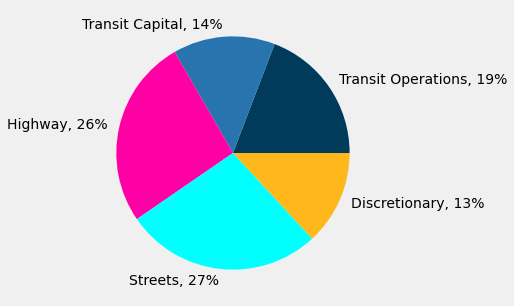

In [123]:
county_lost_chart(measures, 'Contra Costa')

In [33]:
la_joined

,Entity Name,Passenger Fares_ Actual_Operating Revenues,Park-and-Ride Parking Revenues_ Actual_Operating Revenues,School Bus Service Revenues_Nonpublic Transportation Revenues_ Actual_Operating Revenues,Other Nonpublic Transportation Revenues_Nonpublic Transportation Revenues_ Actual_Operating Revenues,Auxiliary Transportation Funds_ Actual_Operating Revenues,Revenues Accrued through a Purchased Transportation Agreement_ Actual_Operating Revenues,Subsidy from Other Sectors of Operations_ Actual_Operating Revenues,Other Operating Revenues_ Actual_Operating Revenues,Total Operating Revenues_ Actual_Operating Revenues,...,Other Nonadded Revenues_Nonadded Revenues_ Actual_Nonoperating Revenues,Total Recoveries_ Actual_Nonoperating Revenues,Other Nonoperating Revenues_ Actual_Nonoperating Revenues,Total Nonoperating Revenues_ Actual_Nonoperating Revenues,Total_Revenues,Other,State TDA,Federal,Local,Fares
Entity ID,,,,,,,,,,,,,,,,,,,,,
12604,Access Services for Los Angeles County CTSA - ...,10260845.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10260845,...,NaN,NaN,196555.0,167545396,177806241,720270.0,NaN,72012866.0,94812260.0,10260845.0
447,Antelope Valley Transit Authority,4826578.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4826578,...,NaN,NaN,808735.0,38361315,43187893,7030265.0,NaN,15830756.0,15500294.0,4826578.0
448,Arcadia,12613.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12613,...,NaN,NaN,NaN,1008707,1021320,0.0,399265.0,0.0,609442.0,12613.0
13119,Burbank,189786.0,NaN,NaN,NaN,6399.0,NaN,NaN,NaN,196185,...,NaN,NaN,NaN,1869377,2065562,6399.0,NaN,0.0,1869377.0,189786.0
13120,Burbank - Specialized Service,18684.0,NaN,NaN,25632.0,NaN,NaN,NaN,NaN,44316,...,NaN,NaN,NaN,2455053,2499369,25632.0,NaN,0.0,2455053.0,18684.0
478,Claremont,37649.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37649,...,NaN,NaN,NaN,623678,661327,36000.0,169093.0,0.0,418585.0,37649.0
485,Commerce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,6046775,6046775,0.0,1208439.0,2530000.0,2308336.0,NaN
484,Commerce - Specialized Service,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,0,0,0.0,NaN,0.0,0.0,NaN
492,Culver City,2908933.0,NaN,NaN,NaN,303281.0,NaN,NaN,785690.0,3997904,...,NaN,NaN,331546.0,19923075,23920979,1420517.0,5923441.0,3985303.0,9682785.0,2908933.0


no matching LOST for Alpine
no matching LOST for Amador
no matching LOST for Humboldt
no matching LOST for San Luis Obispo
no matching LOST for Kern
no matching LOST for Placer
no matching LOST for Butte
no matching LOST for Calaveras
no matching LOST for Kings
no matching LOST for Ventura


<ipython-input-39-dc4878a2dec0>:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(200,200))


no matching LOST for Colusa
no matching LOST for Plumas
no matching LOST for Yolo
no matching LOST for Shasta
no matching LOST for Solano
no matching LOST for Inyo
no matching LOST for Mono
no matching LOST for El Dorado
no matching LOST for Glenn
no matching LOST for Lake
no matching LOST for Lassen
Chart failed for nan
no matching LOST for Mariposa
no matching LOST for Mendocino
no matching LOST for Modoc
no matching LOST for Nevada
no matching LOST for Del Norte
no matching LOST for Sierra
no matching LOST for Siskiyou
no matching LOST for Tehama
no matching LOST for Trinity
no matching LOST for Tuolumne
no matching LOST for Sutter


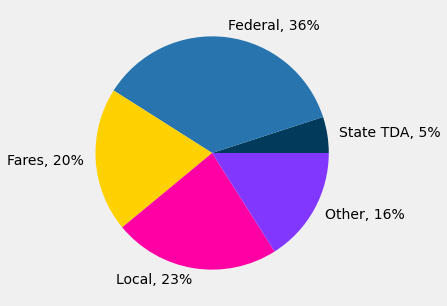

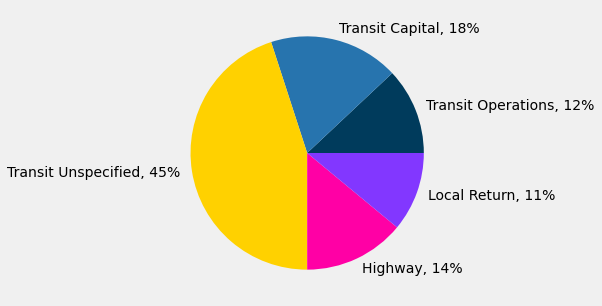

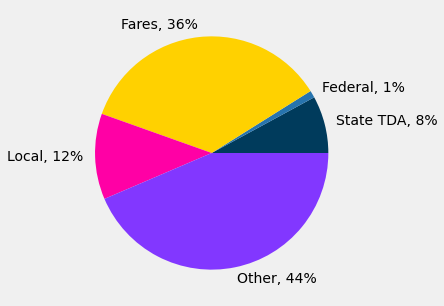

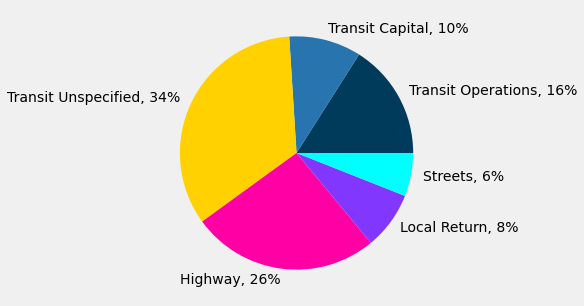

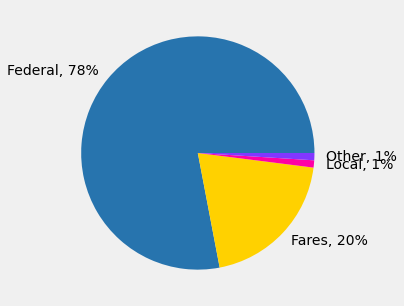

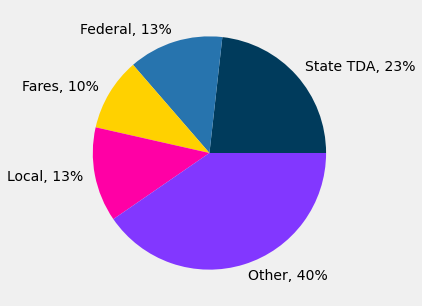

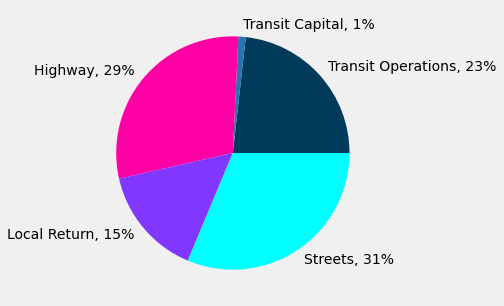

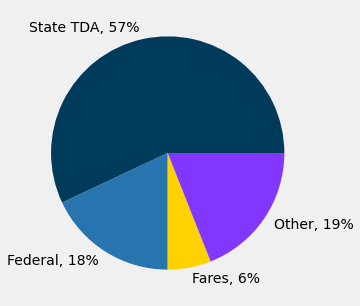

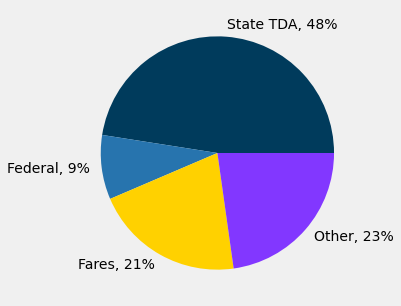

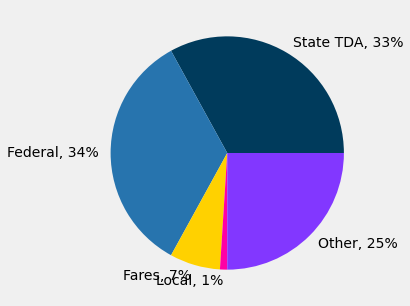

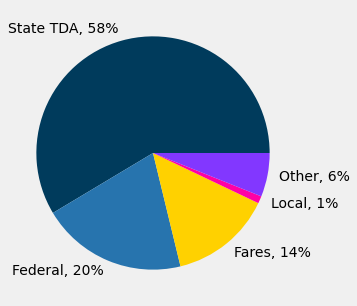

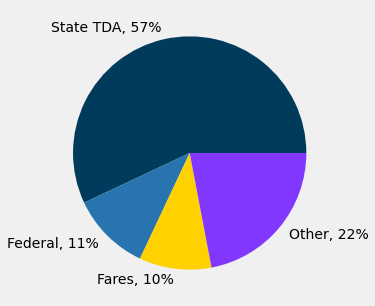

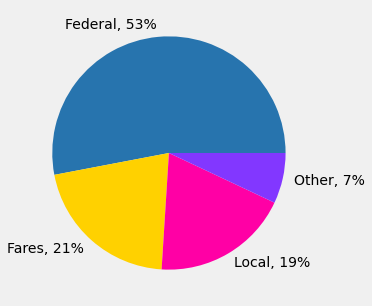

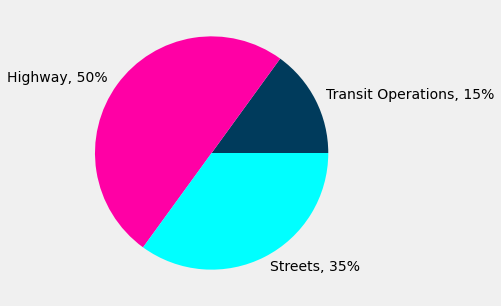

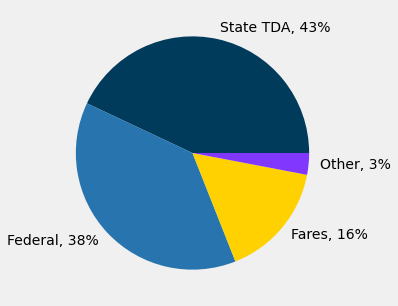

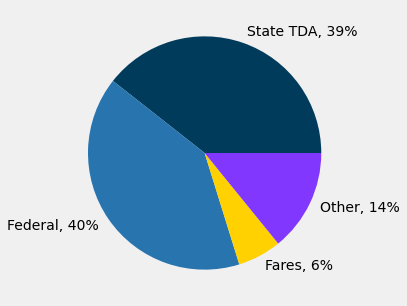

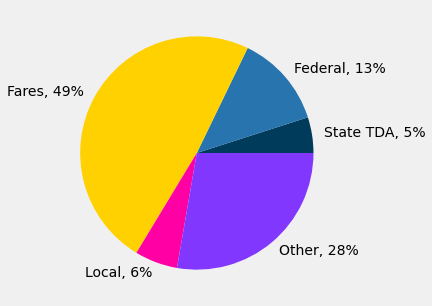

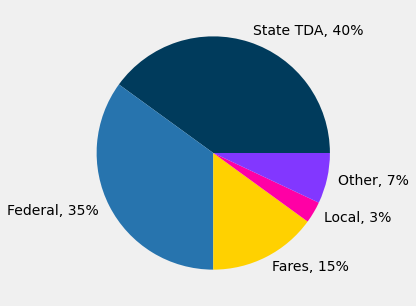

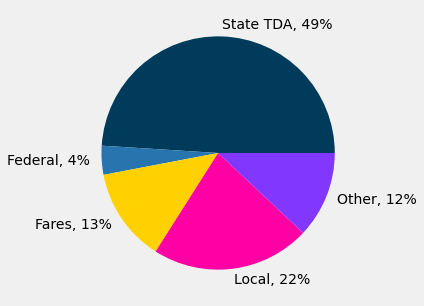

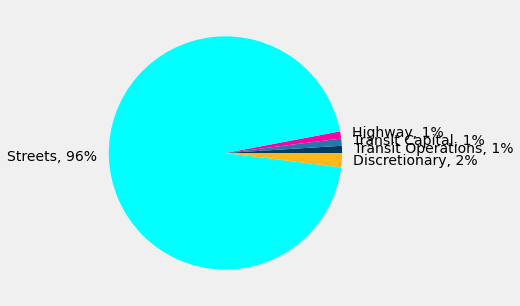

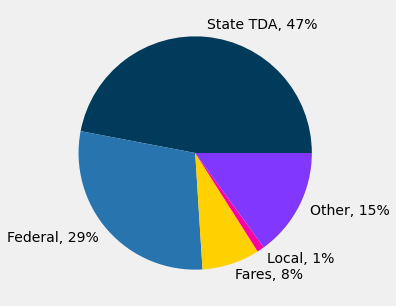

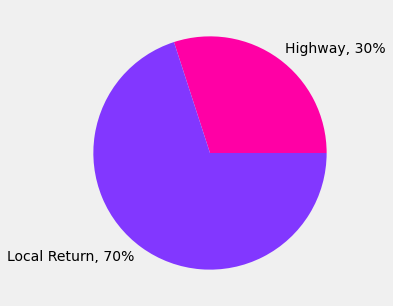

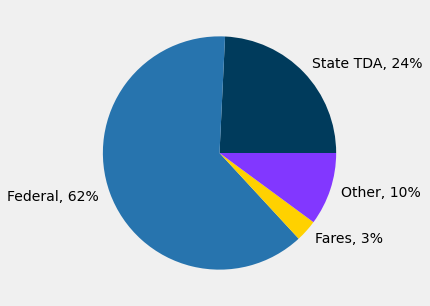

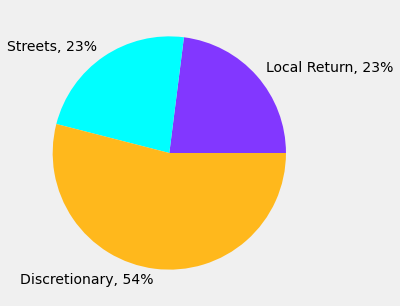

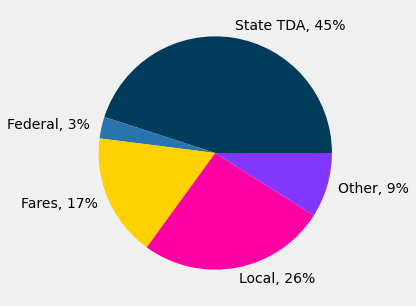

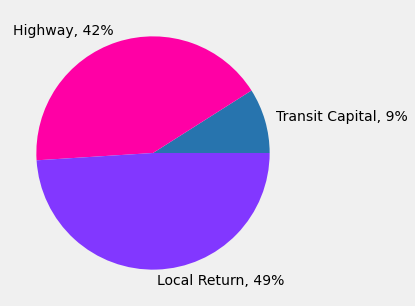

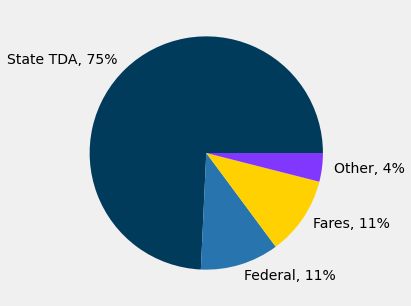

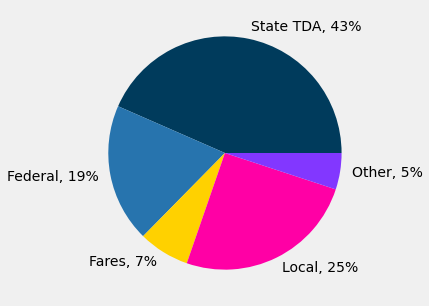

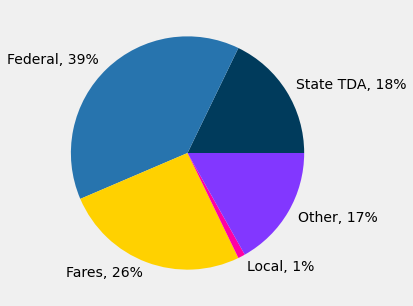

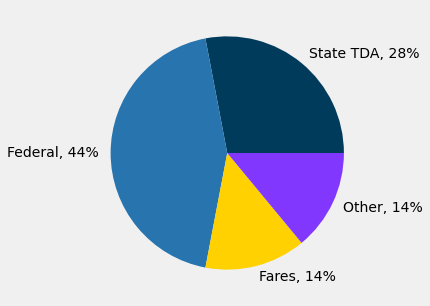

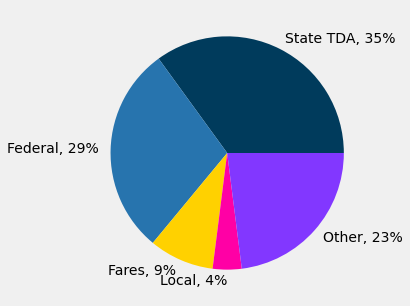

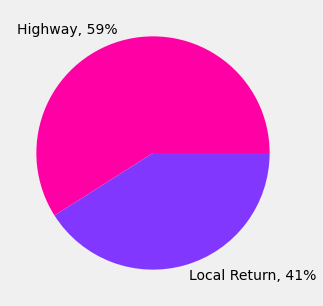

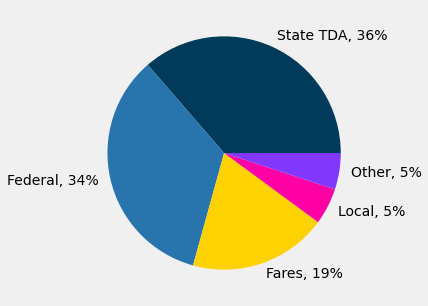

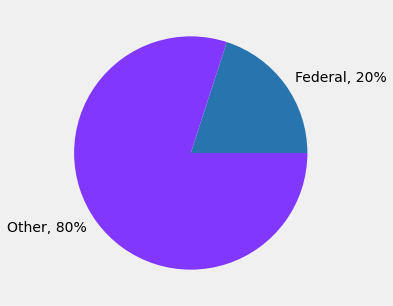

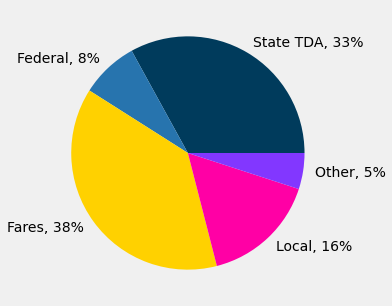

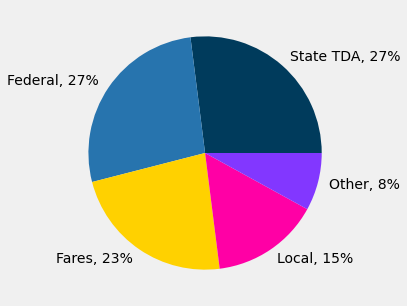

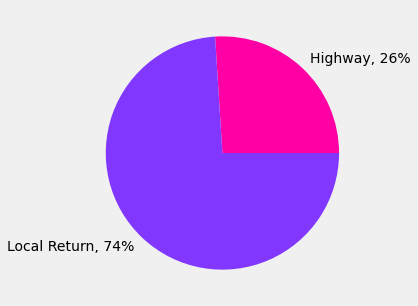

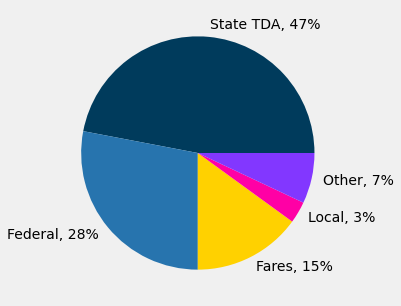

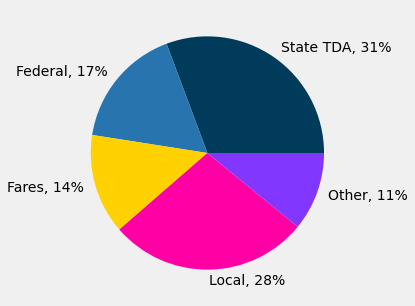

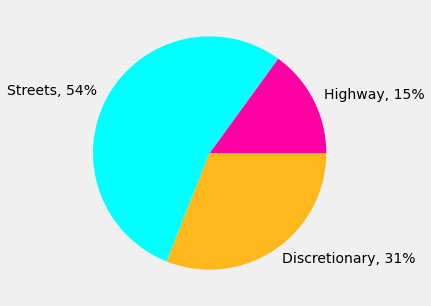

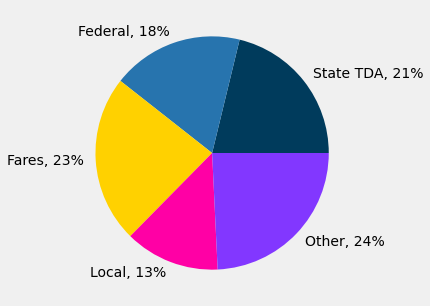

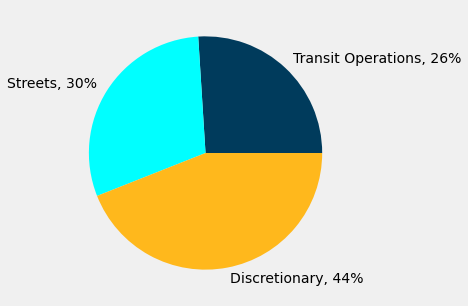

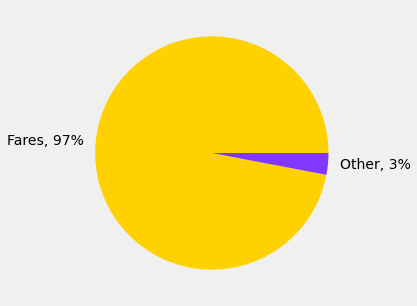

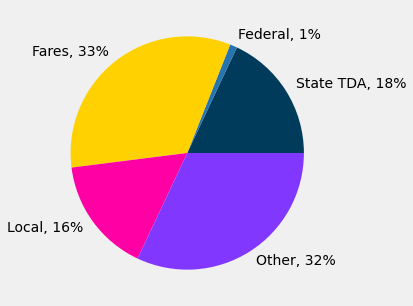

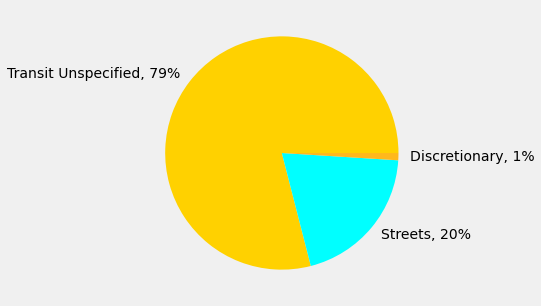

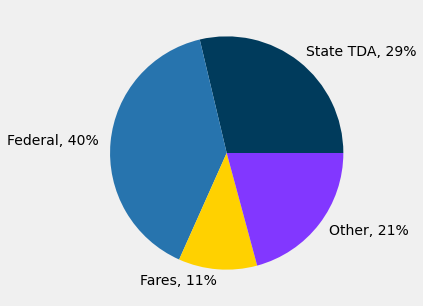

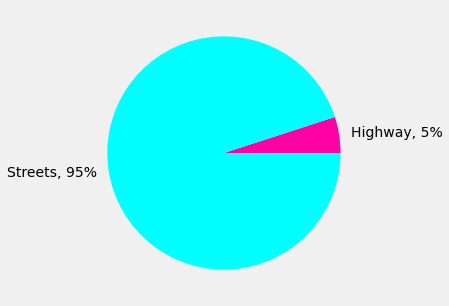

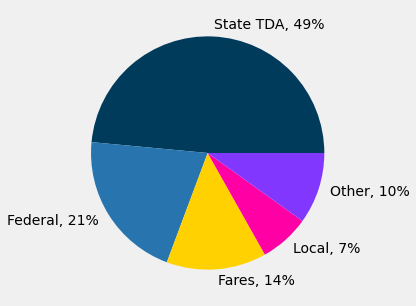

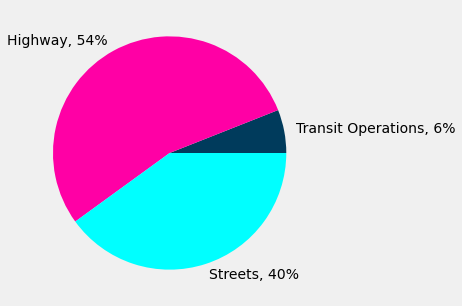

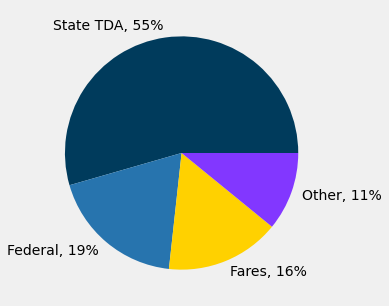

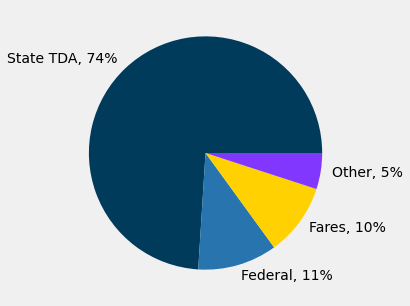

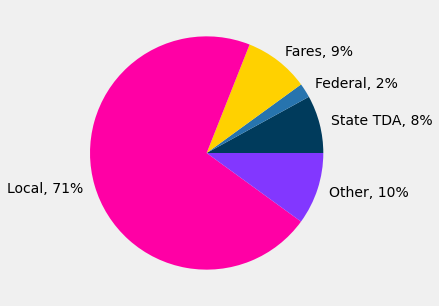

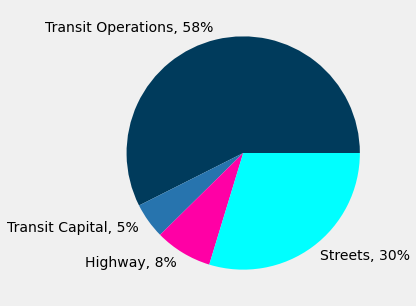

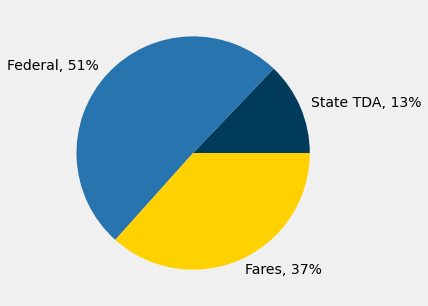

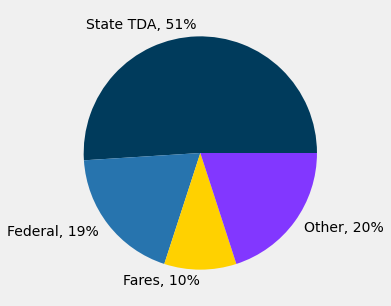

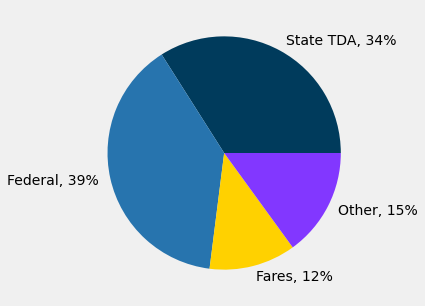

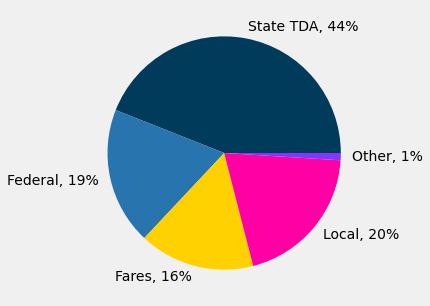

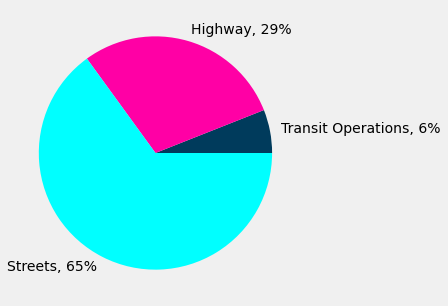

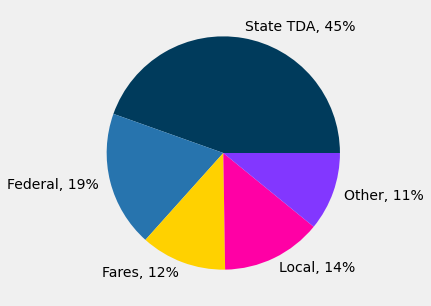

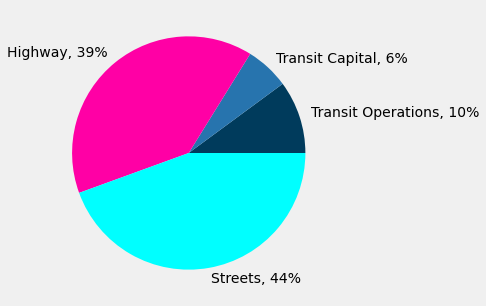

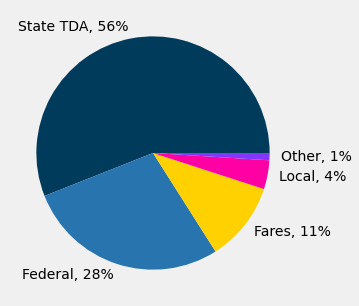

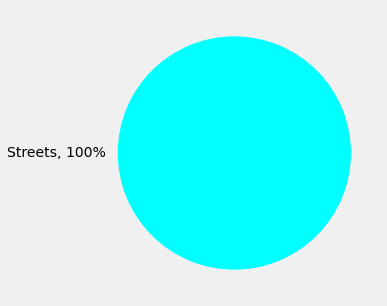

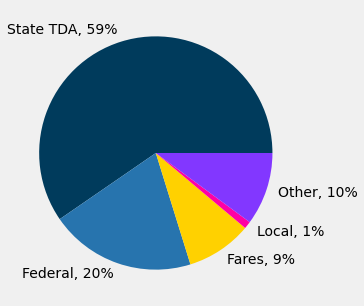

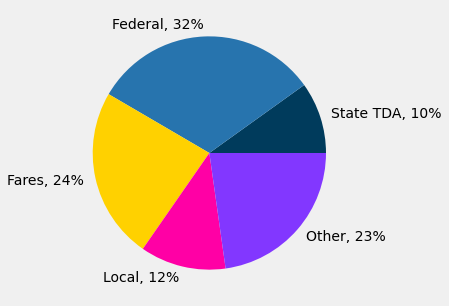

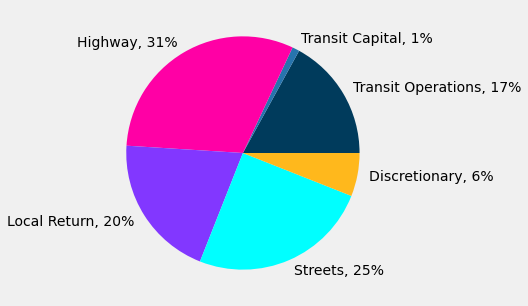

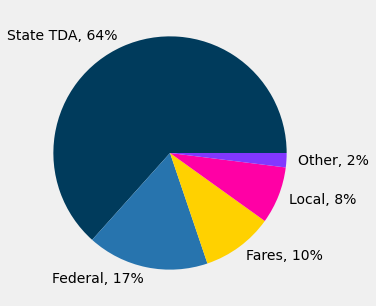

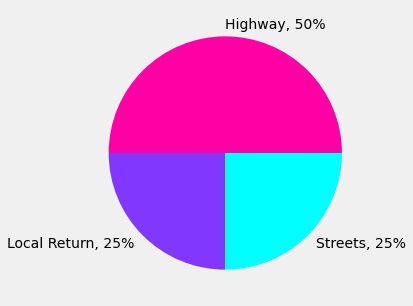

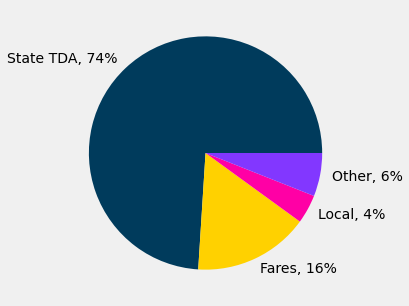

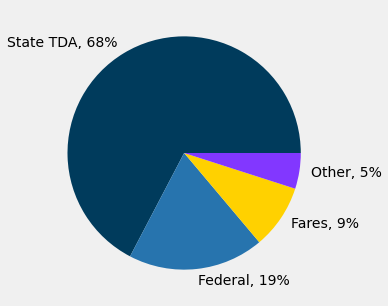

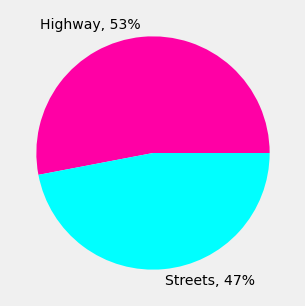

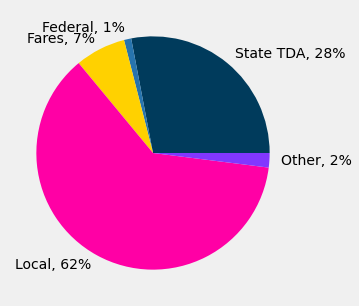

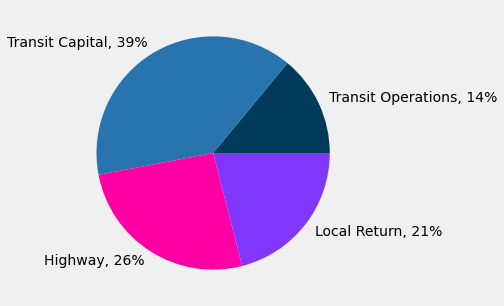

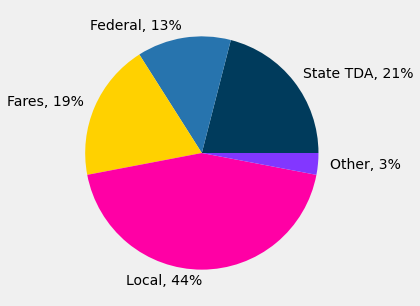

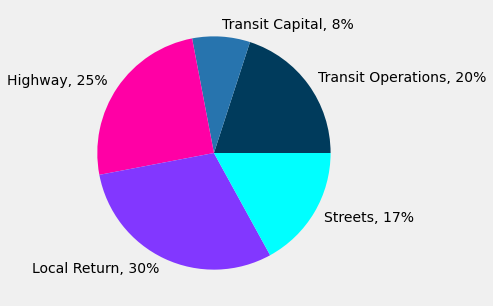

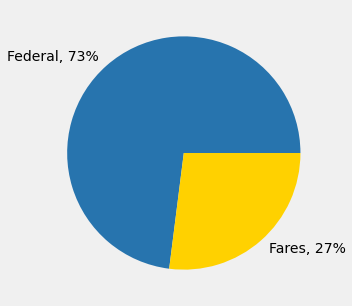

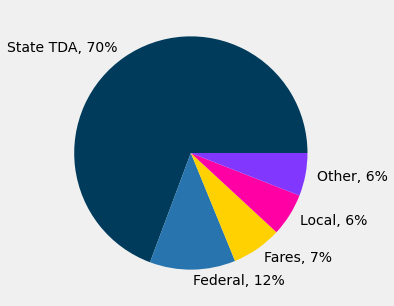

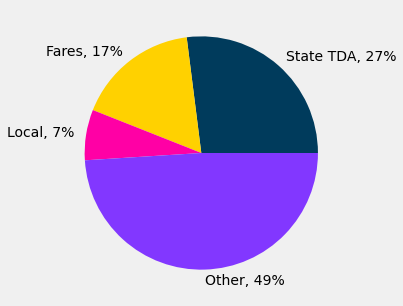

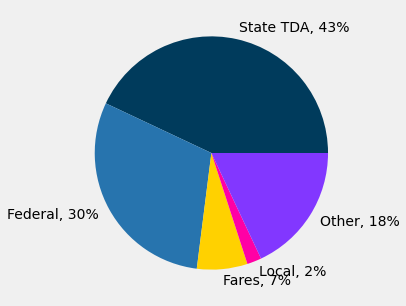

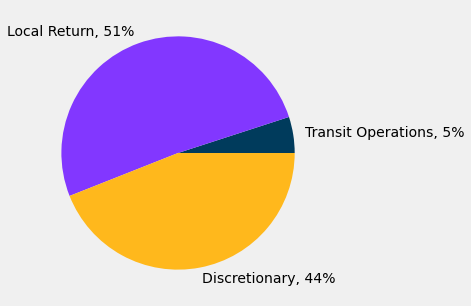

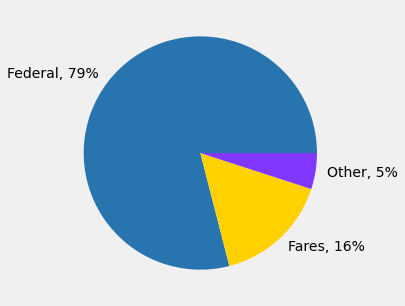

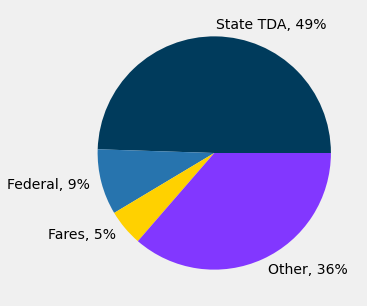

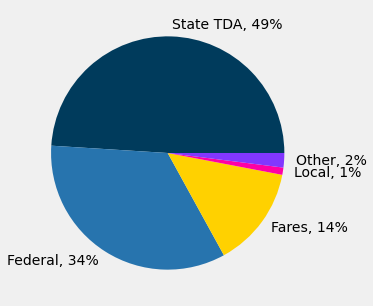

In [41]:
all_county_sco()

### Transit Operators
* LA Metro
* Foothill Transit
* Santa Monica Big Blue Bus
* Culver City Bus
* Torrance Transit

2019 ridership, modes operated, 

_chart of transit funding sources across all operators_

_statistics about transit ridership, rider demographics..._

### Narrative/Passenger Fares and TDA?
(our estimate of countywide farebox requirement, LOST operations resources?)